In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# ✅ STEP 0: Importing libraries and configuring GPU
print("✅ STEP 0: Importing libraries and configuring GPU")

import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import preprocess_input

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print("✅ STEP 0 Completed. Proceeding to STEP 1: Define Paths and Parameters...")


✅ STEP 0: Importing libraries and configuring GPU


2025-06-21 19:58:46.109061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750535926.370635      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750535926.447553      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ STEP 0 Completed. Proceeding to STEP 1: Define Paths and Parameters...


In [2]:
# ✅ STEP 1: Define Paths and Parameters
print("✅ STEP 1: Defining dataset paths and model parameters...")

BASE_PATH = "/kaggle/working/dataset"
TRAIN_DIR = os.path.join(BASE_PATH, "train")
VAL_DIR = os.path.join(BASE_PATH, "val")
TEST_DIR = os.path.join(BASE_PATH, "test")

# Model save path
MODEL_SAVE_PATH = "best_efficientnetb3_model.keras"

# Image and training settings
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 30
FINE_TUNE_EPOCHS = 10
PATIENCE = 5

print("✅ STEP 1 Completed. Proceeding to STEP 2: Create ImageDataGenerators and Load Dataset...")


✅ STEP 1: Defining dataset paths and model parameters...
✅ STEP 1 Completed. Proceeding to STEP 2: Create ImageDataGenerators and Load Dataset...


In [6]:
print("✅ STEP 2 (Reloaded): Loading dataset using image_dataset_from_directory...")

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Paths to your dataset
BASE_PATH = "/kaggle/working/dataset"
TRAIN_DIR = f"{BASE_PATH}/train"
VAL_DIR = f"{BASE_PATH}/val"
TEST_DIR = f"{BASE_PATH}/test"

# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64  # Using higher batch size with 16GB GPU

# Load datasets
train_data = image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='binary',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_data = image_dataset_from_directory(
    VAL_DIR,
    label_mode='binary',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test_data = image_dataset_from_directory(
    TEST_DIR,
    label_mode='binary',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

print("✅ STEP 2 Completed. Proceed to STEP 4 again.")


✅ STEP 2 (Reloaded): Loading dataset using image_dataset_from_directory...
Found 140000 files belonging to 2 classes.
Found 40000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
✅ STEP 2 Completed. Proceed to STEP 4 again.


In [7]:
print("✅ STEP 3: Building EfficientNetB3 model...")

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# Set mixed precision for speed (if supported)
mixed_precision.set_global_policy('mixed_float16')

# Define input shape and base model
inputs = Input(shape=(224, 224, 3))
base_model = EfficientNetB3(include_top=False, input_tensor=inputs, weights='imagenet')
base_model.trainable = False  # freeze base model for phase 1

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid', dtype='float32')(x)  # force output to float32

# Define final model
model = Model(inputs=inputs, outputs=outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Summary
model.summary()
print("✅ STEP 3 Completed. Proceed to STEP 4: Training (Phase 1)...")


✅ STEP 3: Building EfficientNetB3 model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_4 (Cast)             │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ cast_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce    

 Total params: 10,980,400 (41.89 MB)

 Trainable params: 196,865 (769.00 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

✅ STEP 3 Completed. Proceed to STEP 4: Training (Phase 1)...


In [8]:
print("✅ STEP 4: Training model (Phase 1 - frozen EfficientNetB3)...")

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Paths for saving models
PHASE1_MODEL_PATH = "best_model_phase1.keras"

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)
checkpoint1 = ModelCheckpoint(PHASE1_MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

# Train
history1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop, lr_reduce, checkpoint1]
)

print("✅ STEP 4 Completed. Proceed to STEP 5: Fine-tuning base model...")


✅ STEP 4: Training model (Phase 1 - frozen EfficientNetB3)...
Epoch 1/10


I0000 00:00:1750540430.838719     321 service.cc:148] XLA service 0x79fd1841d030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750540430.839780     321 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750540434.136761     321 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2188 ━━━━━━━━━━━━━━━━━━━━ 29:49:27 49s/step - accuracy: 0.5469 - auc: 0.5400 - loss: 0.7027

I0000 00:00:1750540452.273881     321 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6273 - auc: 0.6784 - loss: 0.6396
Epoch 1: val_accuracy improved from -inf to 0.71387, saving model to best_model_phase1.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 253s 93ms/step - accuracy: 0.6273 - auc: 0.6784 - loss: 0.6396 - val_accuracy: 0.7139 - val_auc: 0.8060 - val_loss: 0.5472 - learning_rate: 1.0000e-04
Epoch 2/10
2187/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6919 - auc: 0.7681 - loss: 0.5694
Epoch 2: val_accuracy improved from 0.71387 to 0.73577, saving model to best_model_phase1.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 180s 82ms/step - accuracy: 0.6919 - auc: 0.7681 - loss: 0.5694 - val_accuracy: 0.7358 - val_auc: 0.8346 - val_loss: 0.5133 - learning_rate: 1.0000e-04
Epoch 3/10
2187/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7094 - auc: 0.7940 - loss: 0.5432
Epoch 3: val_accuracy improved from 0.73577 to 0.75020, saving model to best_model_phase1.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 182s 83ms/step - accur

In [9]:
print("✅ STEP 5: Fine-tuning EfficientNetB3...")

# Unfreeze the entire EfficientNetB3 base model
base_model.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # smaller LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Callbacks for phase 2
PHASE2_MODEL_PATH = "best_model_finetuned.keras"
checkpoint2 = ModelCheckpoint(PHASE2_MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

# Fine-tune
history2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop, lr_reduce, checkpoint2]
)

print("✅ STEP 5 Completed. Proceed to STEP 6: Evaluation and Graphs...")


✅ STEP 5: Fine-tuning EfficientNetB3...
Epoch 1/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.6848 - auc: 0.7569 - loss: 0.6179
Epoch 1: val_accuracy improved from -inf to 0.85957, saving model to best_model_finetuned.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 737s 263ms/step - accuracy: 0.6849 - auc: 0.7569 - loss: 0.6178 - val_accuracy: 0.8596 - val_auc: 0.9481 - val_loss: 0.2944 - learning_rate: 1.0000e-05
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8504 - auc: 0.9401 - loss: 0.3072
Epoch 2: val_accuracy improved from 0.85957 to 0.90895, saving model to best_model_finetuned.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 496s 227ms/step - accuracy: 0.8504 - auc: 0.9401 - loss: 0.3072 - val_accuracy: 0.9089 - val_auc: 0.9796 - val_loss: 0.1794 - learning_rate: 1.0000e-05
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8979 - auc: 0.9731 - loss: 0.2038
Epoch 3: val_accuracy improved from 0.90895 to 0.92510, saving model to best_model_fine

✅ STEP 6: Evaluation & Graphs...
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9744 - auc: 0.5023 - loss: 0.0443

🎯 Test Accuracy: 95.36%
🎯 Test AUC: 0.9943
🎯 Test Loss: 0.0919


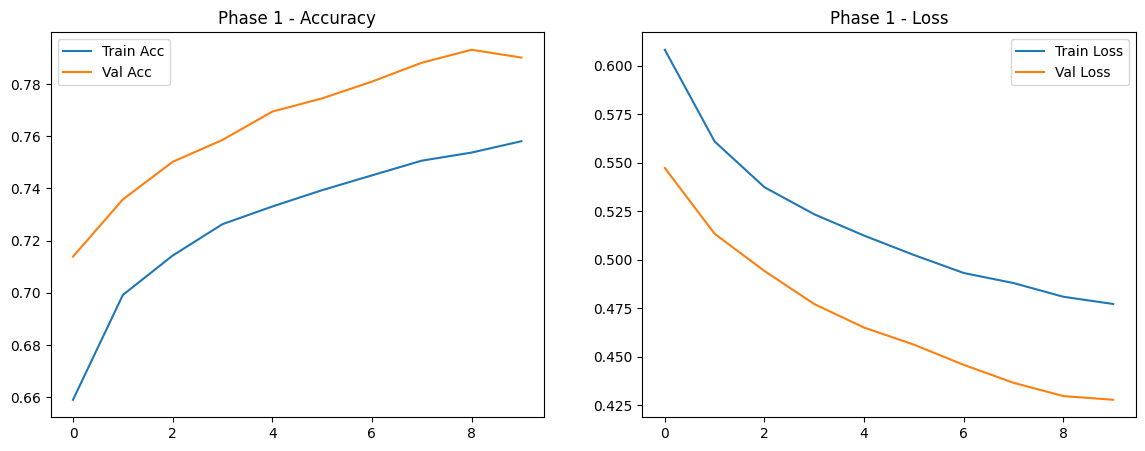

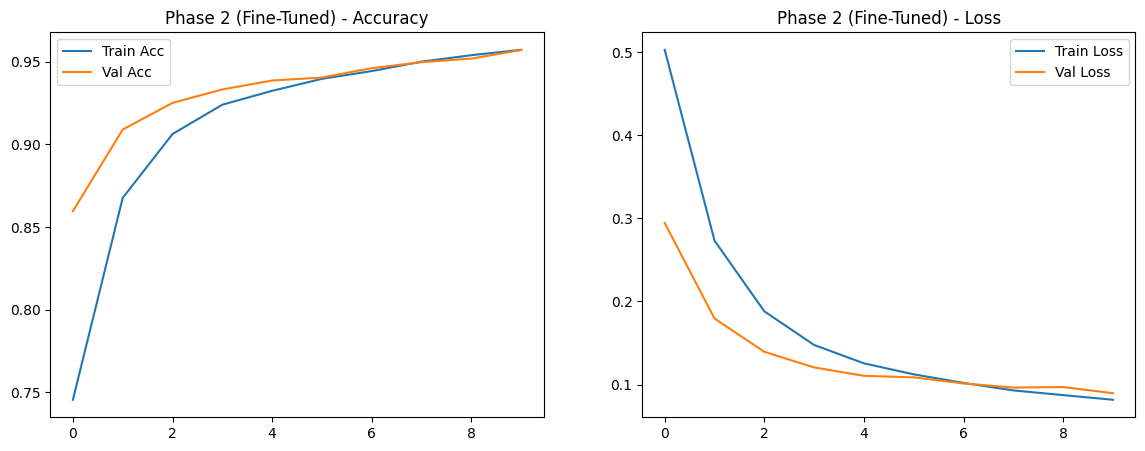

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━

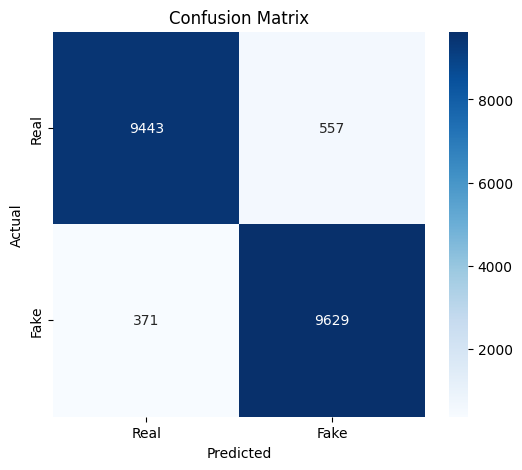


📊 Classification Report:
              precision    recall  f1-score   support

        Real       0.96      0.94      0.95     10000
        Fake       0.95      0.96      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2

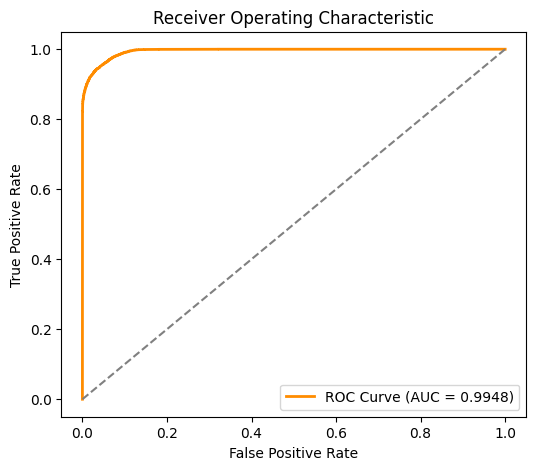

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np

# STEP 6: Evaluation & Visualizations
print("✅ STEP 6: Evaluation & Graphs...")

# 1. Final Evaluation on Test Set
loss, accuracy, auc_score = model.evaluate(test_data)
print(f"\n🎯 Test Accuracy: {accuracy*100:.2f}%")
print(f"🎯 Test AUC: {auc_score:.4f}")
print(f"🎯 Test Loss: {loss:.4f}")

# 2. Training Curves (Accuracy & Loss)
def plot_history(history, title):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

plot_history(history1, "Phase 1")
plot_history(history2, "Phase 2 (Fine-Tuned)")

# 3. Confusion Matrix & Classification Report
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32"))

cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Real", "Fake"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\n📊 Classification Report:")
print(report)

# 4. ROC Curve
y_probs = []  # probabilities
y_true = []

for images, labels in test_data:
    probs = model.predict(images)
    y_probs.extend(probs)
    y_true.extend(labels.numpy())

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()


Found 20000 files belonging to 2 classes.
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step
✅ Test Accuracy: 95.36%
✅ Test AUC: 0.9948

Classification Report:

              precision    recall  f1-score   support

        fake       0.96      0.94      0.95     10000
        real       0.95      0.96      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



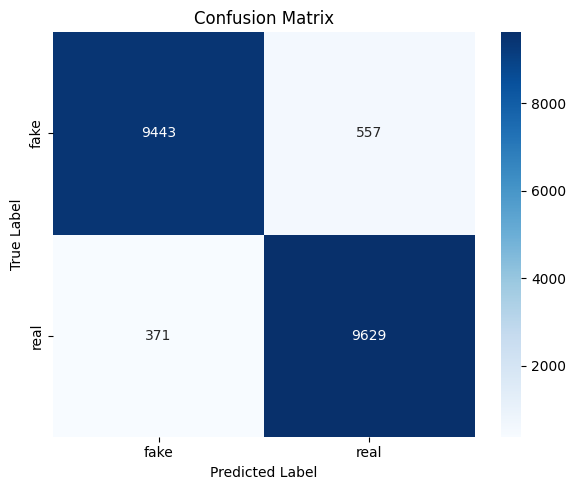

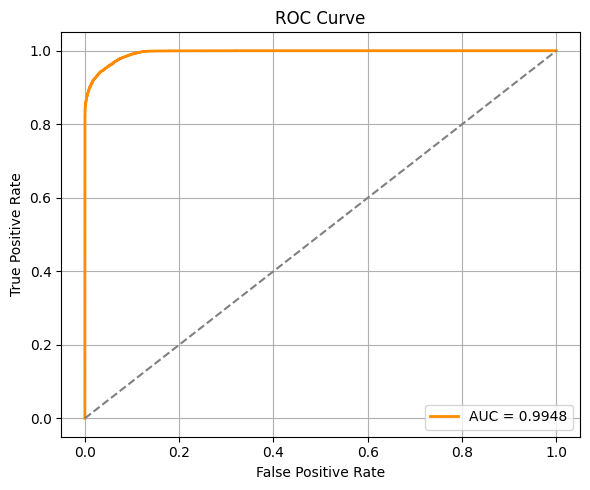

⚠️ training_history.pkl not found. Please save it during training using:
with open('/kaggle/working/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory

# Step 1: Load Trained Model
model = load_model("/kaggle/working/best_model_finetuned.keras")

# Step 2: Load Test Data
test_path = "/kaggle/working/dataset/test"
test_data = image_dataset_from_directory(
    test_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    label_mode="int"
)
class_names = test_data.class_names

# Step 3: Predict on Test Data
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred_probs = model.predict(test_data)
y_pred = (y_pred_probs > 0.5).astype("int32").ravel()

# Step 4: Metrics
fpr, tpr, _ = roc_curve(y_true, y_pred_probs.ravel())
roc_auc = auc(fpr, tpr)
acc = np.mean(y_pred == y_true)

print(f"✅ Test Accuracy: {acc * 100:.2f}%")
print(f"✅ Test AUC: {roc_auc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Step 5: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Step 6: ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 7: Plot Training History (accuracy, loss, auc if available)
history_path = "/kaggle/working/training_history.pkl"
if os.path.exists(history_path):
    with open(history_path, "rb") as f:
        history = pickle.load(f)

    # Plot Accuracy and Loss
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Acc')
    plt.plot(history['val_accuracy'], label='Val Acc')
    plt.title('Epoch-wise Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Epoch-wise Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot AUC if available
    if 'auc' in history:
        plt.figure(figsize=(6, 4))
        plt.plot(history['auc'], label='Train AUC')
        plt.plot(history['val_auc'], label='Val AUC')
        plt.title('Epoch-wise AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ training_history.pkl not found. Please save it during training using:")
    print("with open('/kaggle/working/training_history.pkl', 'wb') as f:\n    pickle.dump(history.history, f)")


In [39]:
# Save the best model (if not already saved)
model.save("/kaggle/working/best_model_finetuned.keras")


In [40]:
import shutil

# Path to save zipped output
output_zip_path = "/kaggle/working/deepfake_model_dataset.zip"

# Create a temporary folder to zip
temp_folder = "/kaggle/working/final_package"
os.makedirs(temp_folder, exist_ok=True)

# Copy model
shutil.copy("/kaggle/working/best_model_finetuned.keras", f"{temp_folder}/best_model_finetuned.keras")

# Copy dataset folders (train, val, test)
shutil.copytree("/kaggle/working/dataset/train", f"{temp_folder}/train")
shutil.copytree("/kaggle/working/dataset/val", f"{temp_folder}/val")
shutil.copytree("/kaggle/working/dataset/test", f"{temp_folder}/test")

# Zip it
shutil.make_archive(base_name=output_zip_path.replace(".zip", ""), format='zip', root_dir=temp_folder)

print("✅ Model + dataset zipped successfully!")


✅ Model + dataset zipped successfully!


In [41]:
from IPython.display import FileLink

# Create clickable download link in notebook
FileLink("/kaggle/working/deepfake_model_dataset.zip")


/kaggle/working/deepfake_model_dataset.zip

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted: Real (0.0113)


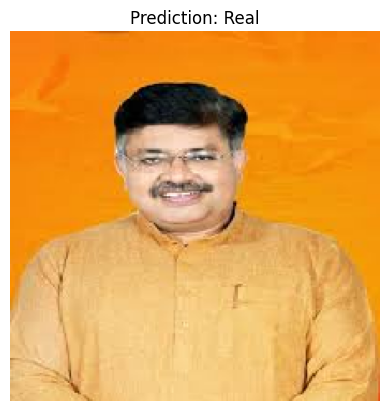

In [51]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

# ✅ Load a single image
img_path = "/kaggle/input/fortesting/Real3.jfif"  # Upload image here
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_array)

# ✅ Make prediction
prediction = model.predict(img_preprocessed)[0][0]
label = "Fake" if prediction > 0.5 else "Real"

print(f"Predicted: {label} ({prediction:.4f})")

# ✅ Show image
plt.imshow(img)
plt.title(f"Prediction: {label}")
plt.axis("off")
plt.show()


In [ ]:
print("✅ STEP 5: Fine-tuning EfficientNetB3 (Extended Epochs)...")

# Unfreeze the base model
base_model.trainable = True

# Compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # fine-tuning uses low LR
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

PHASE2_MODEL_PATH = "best_model_finetuned_v2.keras"

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint2 = ModelCheckpoint(PHASE2_MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

# Train for more epochs (30 instead of 10)
history2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stop, lr_reduce, checkpoint2]
)

print("✅ Fine-tuning Completed with 30 Epochs.")


✅ STEP 5: Fine-tuning EfficientNetB3 (Extended Epochs)...
Epoch 1/30
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9602 - auc: 0.9959 - loss: 0.0773
Epoch 1: val_accuracy improved from -inf to 0.95837, saving model to best_model_finetuned_v2.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 732s 262ms/step - accuracy: 0.9602 - auc: 0.9959 - loss: 0.0773 - val_accuracy: 0.9584 - val_auc: 0.9947 - val_loss: 0.0882 - learning_rate: 1.0000e-05
Epoch 2/30
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9645 - auc: 0.9967 - loss: 0.0706
Epoch 2: val_accuracy improved from 0.95837 to 0.96135, saving model to best_model_finetuned_v2.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 499s 228ms/step - accuracy: 0.9645 - auc: 0.9967 - loss: 0.0706 - val_accuracy: 0.9614 - val_auc: 0.9951 - val_loss: 0.0865 - learning_rate: 1.0000e-05
Epoch 3/30
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9670 - auc: 0.9970 - loss: 0.0665
Epoch 3: val_accuracy improved from 0.96135 to 0.96275, saving 